---
**License**

 TestInterp

 Mon Jan 25 20:56:00 2020\
 Copyright  2021\
 Eduardo ...\
 Sandro Dias Pinto Vitenti <vitenti@uel.br>

---
---

 TestInterp\
 Copyright (C) 2021 Eduardo ...\
 Copyright (C) 2021 Sandro Dias Pinto Vitenti <vitenti@uel.br>


 numcosmo is free software: you can redistribute it and/or modify it
 under the terms of the GNU General Public License as published by the
 Free Software Foundation, either version 3 of the License, or
 (at your option) any later version.

 numcosmo is distributed in the hope that it will be useful, but
 WITHOUT ANY WARRANTY; without even the implied warranty of
 MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
 See the GNU General Public License for more details.

 You should have received a copy of the GNU General Public License along
 with this program.  If not, see <http://www.gnu.org/licenses/>.
 
---

In [1]:
try:
  import gi
  gi.require_version('NumCosmo', '1.0')
  gi.require_version('NumCosmoMath', '1.0')
except:
  pass

import sys
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats


from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm
%matplotlib inline

In [2]:
__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

In [3]:
dim = 20
p = np.random.random_sample((dim,))
print (p)

[ 0.71155544  0.76154705  0.17929383  0.42800504  0.93505353  0.44286678
  0.09786413  0.97858447  0.16845432  0.71470845  0.56270158  0.37716973
  0.63697281  0.46854531  0.28079642  0.56708988  0.34855678  0.99595406
  0.93676681  0.05023076]


In [4]:
rng = Ncm.RNG.new (None)

fmodel = Ncm.ModelMVND.new (dim)
fdata = Ncm.DataGaussCovMVND.new_full (dim, 0.1, 0.4, 10.0, -1.0, 1.0, rng)

fdata.props.use_norma = True

mset = Ncm.MSet.new_array ([fmodel])
mset.param_set_all_ftype (Ncm.ParamType.FREE)
mset.prepare_fparam_map ()

mset.fparams_set_array (p)
mset.pretty_log ()

#----------------------------------------------------------------------------------
# Model[00000]:
#   - NcmModelMVND : MVND
#----------------------------------------------------------------------------------
# Model parameters
#   -  mu_0[00]:  0.711555442298499   [FREE]
#   -  mu_1[01]:  0.761547048277024   [FREE]
#   -  mu_2[02]:  0.179293829763376   [FREE]
#   -  mu_3[03]:  0.428005044052584   [FREE]
#   -  mu_4[04]:  0.935053531328729   [FREE]
#   -  mu_5[05]:  0.442866780530303   [FREE]
#   -  mu_6[06]:  0.0978641341269827  [FREE]
#   -  mu_7[07]:  0.978584468760377   [FREE]
#   -  mu_8[08]:  0.168454315535077   [FREE]
#   -  mu_9[09]:  0.714708453631569   [FREE]
#   - mu_10[10]:  0.56270158337998    [FREE]
#   - mu_11[11]:  0.377169733251914   [FREE]
#   - mu_12[12]:  0.636972807656849   [FREE]
#   - mu_13[13]:  0.468545306981003   [FREE]
#   - mu_14[14]:  0.280796423892306   [FREE]
#   - mu_15[15]:  0.567089876407512   [FREE]
#   - mu_16[16]:  0.348556779181255   [FREE]
#   - 

In [5]:
y_a = []
x_a = []
xn_a = []




interp = Ncm.StatsDistNdKDEStudentt.new (len (p), False, 14)

for a in range (5000):
    v, N = fdata.gen (mset, None, None, rng)
    interp.add_obs (v)
    y_a.append (fdata.m2lnL_val (mset))
    x_a.append (v.dup_array ())

for a in range (5000):
    v, N = fdata.gen (mset, None, None, rng)
    xn_a.append (v.dup_array ())

y_a = np.array (y_a)
x_a = np.array (x_a)
xn_a = np.array (xn_a)

fdata.y.set_array (p)

fdata.m2lnL_val (mset)

-34.47593073502856

In [6]:
#interp.prepare ()
interp.prepare_interp (Ncm.Vector.new_array (y_a))


[-1.99613392 -5.09829689 -2.47367385 ..., -6.4975089  -2.10289915
 -0.24318494]


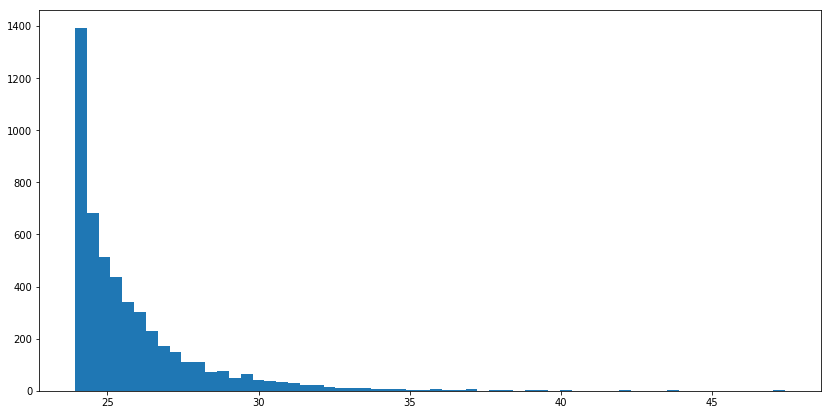

In [7]:
def NormalizeData(data,sample):
    return (data - np.min(sample)) / (np.max(sample) - np.min(sample))
        
yi_a = []
ya_a = []
yi_b = []

for x in x_a:
    mset.fparams_set_array (x)
    fdata.prepare (mset)
    yi_a.append (interp.eval_m2lnp (Ncm.Vector.new_array (x)))
    ya_a.append (fdata.m2lnL_val (mset))

yi_a = np.array (yi_a)
ya_a = np.array (ya_a)

diff = yi_a - ya_a 
print (diff)

reldiff=np.abs(diff/ya_a)
norm, cont = scipy.stats.mode (diff)
diff = diff + norm[0]
plt.figure (figsize=(14, 7))

bla = plt.hist(np.abs(diff), bins = 60)


In [8]:
yi_a = []
ya_a = []

for x in xn_a:
    mset.fparams_set_array (x)
    fdata.prepare (mset)
    yi_a.append (interp.eval_m2lnp (Ncm.Vector.new_array (x)))
    ya_a.append (fdata.m2lnL_val (mset))

yi_a = np.array (yi_a) 
ya_a = np.array (ya_a)

diff = yi_a - ya_a
reldiff = np.abs (diff / ya_a)
for a in range(0,10):
    print (reldiff[a])

#print (ya_a)
#print (yi_a)
print(np.max(ya_a), np.max(diff), np.max(yi_a), np.max(reldiff))
print (np.sum ((reldiff < 0.5)/len(reldiff))*100.0)


0.71581495663
1.60925063883
1.21097272965
0.485181588842
2.64793324442
0.846406519076
0.830154681947
4.77273069003
1.50634606494
0.962656025537
12.4372786764 24.3046982776 27.6310818658 547.872367723
0.8


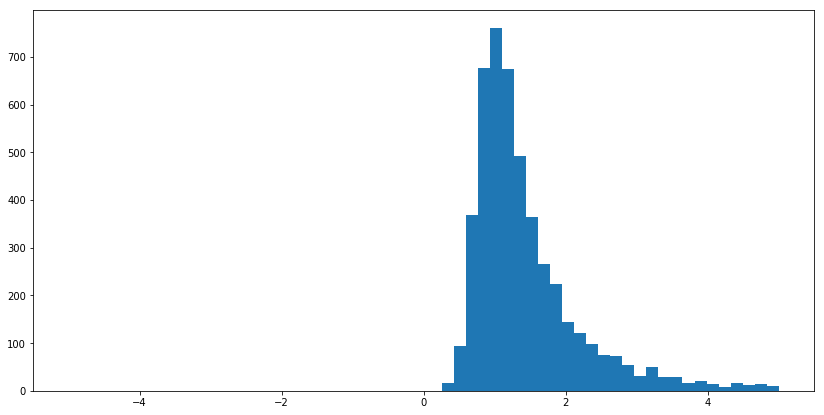

In [9]:
plt.figure (figsize=(14, 7))
bla = plt.hist((reldiff), bins = np.linspace (-5,5,60))
